### Identifying State Transitions in Melanoma During Drug-Induced Idling
C Heiser, Spring 2019  
  
---
The purpose of this work is to use cell lineage tracing via molecular barcodes and single-cell transcriptomic analyses to identify population-level heterogeneity and cell-state plasticity in BRAF-mutated melanoma (SKMEL5). 

Requirements:  
[`codyheiser/seq-tools/`](https://github.com/codyheiser/seq-tools)

In [51]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *
sys.path.append('../seq-tools/'); from seq_analysis import *

%matplotlib inline

### 0. Confirm Barcode Abundance
---
Lineage barcodes are detected in scRNA-seq by poly-T capture of transcribed barcode mRNA. A targeted amplicon sequencing panel was developed to query genomic barcode content to determine global abundance in population, which should corroborate the cell number (*n_cells*) associated with each barcode in scRNA-seq dataset.  

Read in scRNA-seq data with associated barcode UMIs

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 33.6 s, sys: 6.23 s, total: 39.9 s
Wall time: 41.1 s


Normalize barcode counts within each scRNA-seq set 

In [3]:
U_RNA_counts = pd.DataFrame(U.barcode_counts(IDs='all'))
U_RNA_counts_norm = U_RNA_counts.div(U_RNA_counts.sum(axis=0), axis=1)

In [4]:
I_RNA_counts = pd.DataFrame(I.barcode_counts(IDs='all'))
I_RNA_counts_norm = I_RNA_counts.div(I_RNA_counts.sum(axis=0), axis=1)

Read in associated __Read 1__ barcode assay results files, where barcodes were extracted using  
[`codyheiser/seq-tools/seq_extraction.sh`](https://github.com/codyheiser/seq-tools)

In [5]:
%%time
U_R1 = pd.read_csv(gzip.open('untreated/2898-CH-1-CGAAACAT-GTTCAGAG_S1_R1_001.txt.gz'), sep='\t', header=None)
I_R1 = pd.read_csv(gzip.open('idling/2898-CH-2-GGCCACAT-GTTCAGAG_S2_R1_001.txt.gz'), sep='\t', header=None)

CPU times: user 13.1 s, sys: 626 ms, total: 13.7 s
Wall time: 13.9 s


Read in associated __Read 2__ barcode assay results files, where barcodes were extracted using  
[`codyheiser/seq-tools/seq_extraction.sh`](https://github.com/codyheiser/seq-tools)  
and [`codyheiser/seq-tools/rev_comp.sh`](https://github.com/codyheiser/seq-tools)

In [6]:
%%time
U_R2 = pd.read_csv(gzip.open('untreated/2898-CH-1-CGAAACAT-GTTCAGAG_S1_R2_001_REVCOMP.txt.gz'), sep='\t', header=None)
I_R2 = pd.read_csv(gzip.open('idling/2898-CH-2-GGCCACAT-GTTCAGAG_S2_R2_001_REVCOMP.txt.gz'), sep='\t', header=None)

CPU times: user 12.6 s, sys: 673 ms, total: 13.3 s
Wall time: 13.5 s


Now add UMIs from __Read 1__ and __Read 2__ to get totals

In [7]:
U_bc = U_R1.append(U_R2)
I_bc = I_R1.append(I_R2)

Count unique barcode abundances in untreated and idling datasets

In [8]:
U_bc_counts = pd.DataFrame(U_bc[0].value_counts())
U_bc_counts.rename(index=str, columns={0: "Count"}, inplace=True)

In [9]:
I_bc_counts = pd.DataFrame(I_bc[0].value_counts())
I_bc_counts.rename(index=str, columns={0: "Count"}, inplace=True)

Finally, convert counts to fractions of total to normalize for comparison with scRNA-seq data

In [10]:
U_bc_counts_norm = U_bc_counts.div(U_bc_counts.sum(axis=0), axis=1)
I_bc_counts_norm = I_bc_counts.div(I_bc_counts.sum(axis=0), axis=1)

---
Merge scRNA-seq and targeted barcode assay datasets on barcode and print overlay

In [11]:
U_totalcounts = U_RNA_counts_norm.merge(U_bc_counts_norm, left_index=True, right_index=True, how='inner')
U_totalcounts.rename(columns={'Barcode':'U_RNA', 'Count':'U_BC'}, inplace=True)

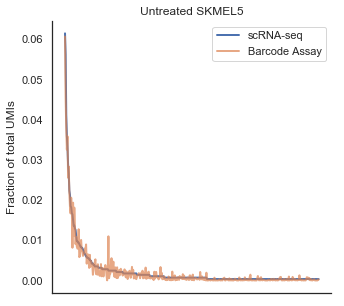

In [12]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(5,5))
U_totalcounts['U_RNA'].plot(label='scRNA-seq', legend=True, linewidth=2)
U_totalcounts['U_BC'].plot(label='Barcode Assay', legend=True, linewidth=2, alpha=0.7)
plt.title('Untreated SKMEL5')
plt.ylabel('Fraction of total UMIs')
sns.despine()
plt.show()

In [13]:
I_totalcounts = I_RNA_counts_norm.merge(I_bc_counts_norm, left_index=True, right_index=True, how='inner')
I_totalcounts.rename(columns={'Barcode':'I_RNA', 'Count':'I_BC'}, inplace=True)

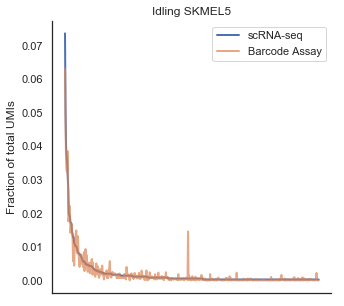

In [14]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(5,5))
I_totalcounts['I_RNA'].plot(label='scRNA-seq', legend=True, linewidth=2)
I_totalcounts['I_BC'].plot(label='Barcode Assay', legend=True, linewidth=2, alpha=0.7)
plt.title('Idling SKMEL5')
plt.ylabel('Fraction of total UMIs')
sns.despine()
plt.show()

Targeted barcode assay __corroborates barcode abundance__ from scRNA-seq results.  
We can confidently trust UMI counts for barcodes in RNA-seq data and use barcode subpopulations to investigate cell state transitions.

### 1. Perform Combined Dimensionality Reduction
---
See if we can detect unique population states in _untreated_ (U) and _idling_ (I) datasets by performing PCA and UMAP together

In [15]:
# combine untreated and idling data to perform combined DR
counts = U.data.append(I.data)

In [16]:
# combine barcode arrays for untreated and idling data
codes = pd.DataFrame(U.barcodes).append(pd.DataFrame(I.barcodes))
codes['Cell Barcode'] = codes.index
codes = codes[~codes.index.duplicated(keep='first')]

In [17]:
counts_obj = RNA_counts(data=counts, barcodes=codes) # generate RNA_counts obj with combined data

In [18]:
# check shape of final counts matrix
counts_obj.data.shape

(6410, 25370)

In [19]:
# select 500 most variable genes
%time counts_vg = RNA_counts.var_select(counts_obj=counts_obj, n_features=500)

CPU times: user 3.5 s, sys: 5.15 s, total: 8.65 s
Wall time: 12.4 s


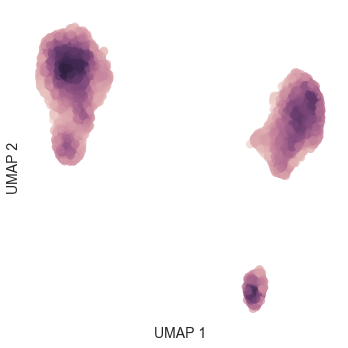

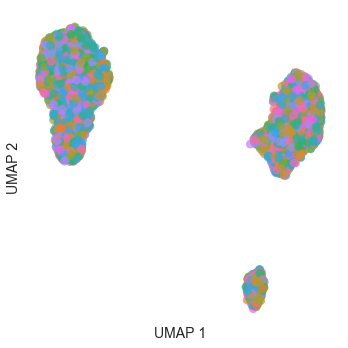

CPU times: user 29 s, sys: 1.53 s, total: 30.5 s
Wall time: 30.4 s


In [170]:
%%time
# perform UMAP on total dataset
counts_UMAP = fcc_UMAP(matrix=counts_vg.arcsinh_norm('l1'), barcodes=counts_obj.barcodes, perplexity=30)
counts_UMAP.plot()
counts_UMAP.plot_barcodes()

Lineage barcodes are distributed seemingly randomly throughout the population.  
Now color by treatment group:

In [69]:
U_codes = pd.DataFrame(U.barcodes)
U_codes['Barcode'] = 'Untreated'
I_codes = pd.DataFrame(I.barcodes)
I_codes['Barcode'] = 'Idling'
# combine barcode arrays for untreated and idling data
codes = U_codes.append(I_codes)
codes = pd.DataFrame(codes)
codes['Cell Barcode'] = codes.index

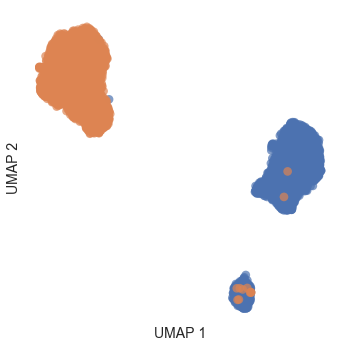

In [72]:
plt.figure(figsize=(5,5))
sns.scatterplot(counts_UMAP.results[:,0], counts_UMAP.results[:,1], s=75, alpha=0.7, hue=codes['Barcode'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

_Untreated_ and _Idling_ cells cluster pretty well.

---
Let's look at upregulation of cell cycle genes to check for cell division clusters

In [67]:
# read in cell cycle genes
cell_cycle = pd.read_csv('resources/metadata_combined.csv')

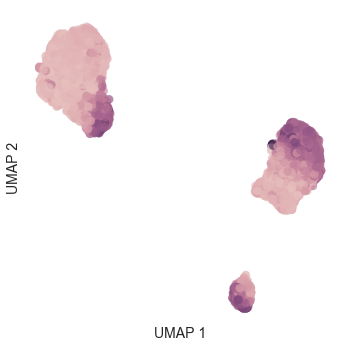

In [68]:
plt.figure(figsize=(5,5))
sns.scatterplot(counts_UMAP.results[:,0], counts_UMAP.results[:,1], s=75, alpha=0.7, hue=cell_cycle['G2M.Score']+cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

### 2. Perform Dimensionality Reduction on Separated treatment datasets
---


Determine high-abundance barcodes to use in both datasets

In [73]:
top20 = list(range(1,21))

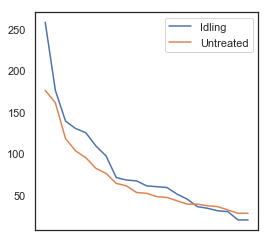

In [141]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
I.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Idling', legend=True)
U.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Untreated', legend=True)
plt.show()

In [75]:
# get list of codes to use throughout the rest of analysis
# top 20 codes in Untreated control set
selected_codes = U.top_barcodes(top20)

Select variable genes in each dataset to prime DRs

In [76]:
# select 150 most variable genes
U_vg = RNA_counts.var_select(counts_obj=U, n_features=500)
I_vg = RNA_counts.var_select(counts_obj=I, n_features=500)

Perform PCA on feature-selected datasets to determine how much variability is explained by PCs

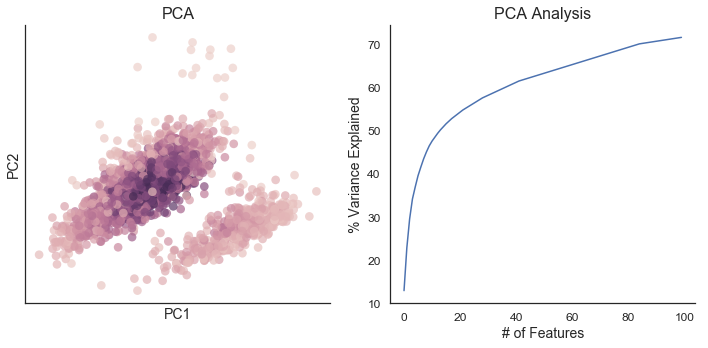

CPU times: user 2.11 s, sys: 282 ms, total: 2.4 s
Wall time: 1.95 s


In [130]:
%%time
U_vg_PCA = fcc_PCA(matrix=U_vg.arcsinh_norm(norm='l1'), barcodes=U_vg.barcodes, n_components=100)
U_vg_PCA.plot()

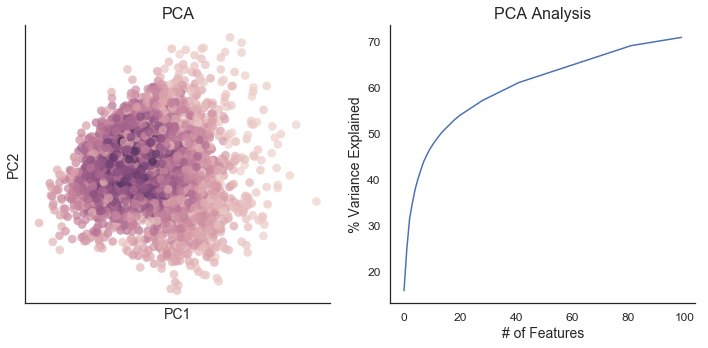

CPU times: user 2.62 s, sys: 253 ms, total: 2.87 s
Wall time: 2.32 s


In [131]:
%%time
I_vg_PCA = fcc_PCA(matrix=I_vg.arcsinh_norm(norm='l1'), barcodes=I_vg.barcodes, n_components=100)
I_vg_PCA.plot()

arcsinh()-normalize to fractional counts in feature-selected dataset and perform UMAP projection

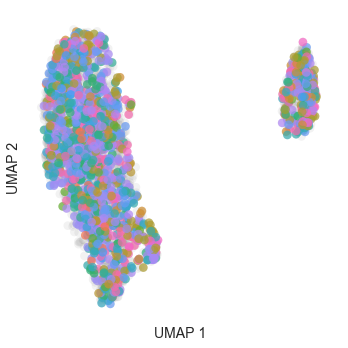

CPU times: user 11.6 s, sys: 879 ms, total: 12.5 s
Wall time: 12.7 s


In [77]:
%%time
U_vg_UMAP = fcc_UMAP(matrix=U_vg.arcsinh_norm(norm='l1'), barcodes=U_vg.barcodes, perplexity=30)
U_vg_UMAP.plot_barcodes(ranks=selected_codes)

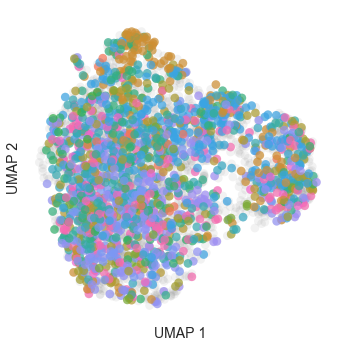

CPU times: user 13.3 s, sys: 571 ms, total: 13.8 s
Wall time: 13.7 s


In [78]:
%%time
I_vg_UMAP = fcc_UMAP(matrix=I_vg.arcsinh_norm(norm='l1'), barcodes=I_vg.barcodes, perplexity=30)
I_vg_UMAP.plot_barcodes(ranks=selected_codes)

--- 
Look at cell cycle genes again in each dataset for good measure

In [79]:
U_cell_cycle = pd.read_csv('untreated/untreated_metadata.csv')
I_cell_cycle = pd.read_csv('idling/treated_metadata.csv')
U_cell_cycle.rename(columns={'Unnamed: 0':'Cell Barcode'}, inplace=True)
I_cell_cycle.rename(columns={'Unnamed: 0':'Cell Barcode'}, inplace=True)

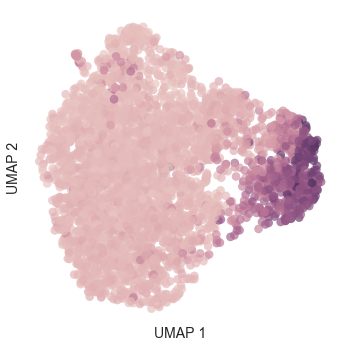

In [80]:
plt.figure(figsize=(5,5))
sns.scatterplot(I_vg_UMAP.results[:,0], I_vg_UMAP.results[:,1], s=75, alpha=0.7, hue=I_cell_cycle['G2M.Score']+I_cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

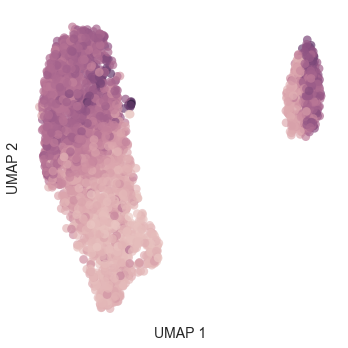

In [81]:
plt.figure(figsize=(5,5))
sns.scatterplot(U_vg_UMAP.results[:,0], U_vg_UMAP.results[:,1], s=75, alpha=0.7, hue=U_cell_cycle['G2M.Score']+U_cell_cycle['S.Score'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

### 3. Calculate EMD Values from Null Population for High-Abundance Clones
---


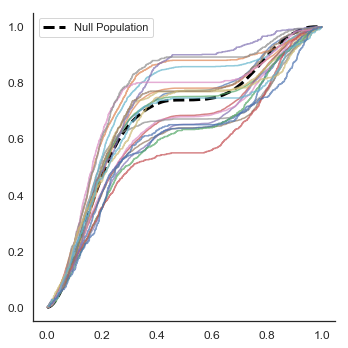

CPU times: user 31.9 s, sys: 1.16 s, total: 33.1 s
Wall time: 33.4 s


In [143]:
%%time
U_out_vg_UMAP = compare_barcode_distances(obj=U_vg_UMAP, barcodes=selected_codes)

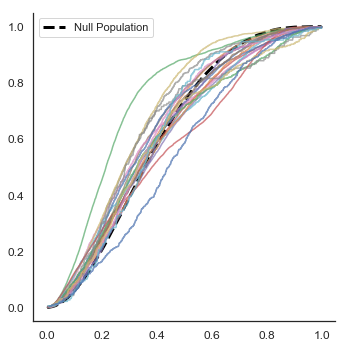

CPU times: user 50.2 s, sys: 1.72 s, total: 52 s
Wall time: 52.2 s


In [144]:
%%time
I_out_vg_UMAP = compare_barcode_distances(obj=I_vg_UMAP, barcodes=selected_codes)

### 4. Create Confidence Interval to Assign Significance to EMD Values
---
Build bias curve of EMD values for random permutations of cells corresponding to range of clonal abundances in datasets.  
Then fit a regression and assign an upper 95% confidence bound function to calculate significance threshold based on *n_cells* in each clonal subpopulation.

In [84]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve_vg_UMAP = cell_bias_curve(obj=U_vg_UMAP, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 4min 1s, sys: 8.26 s, total: 4min 9s
Wall time: 4min 15s


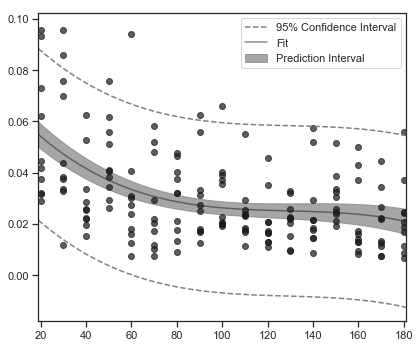

In [106]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_vg_UMAP.melt(id_vars='n_cells')['value'], deg=3)

Do the same as above for __Idling__ dataset

In [86]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve_vg_UMAP = cell_bias_curve(obj=I_vg_UMAP, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 43s, sys: 9.58 s, total: 4min 53s
Wall time: 4min 58s


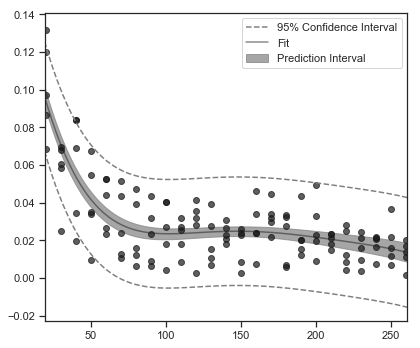

In [105]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_vg_UMAP.melt(id_vars='n_cells')['value'], deg=5)

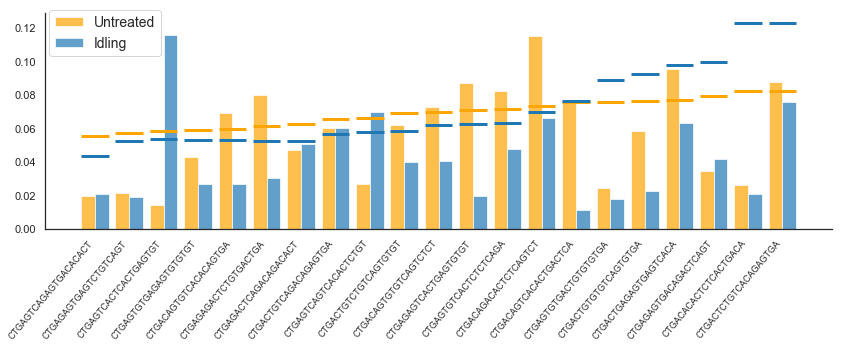

In [112]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out_vg_UMAP.code, height=U_out_vg_UMAP.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out_vg_UMAP.code, height=I_out_vg_UMAP.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve_vg_UMAP.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve_vg_UMAP.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve_vg_UMAP.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc=[0.005,0.8],fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
Look at some significant barcode populations

First, significant idling populations:

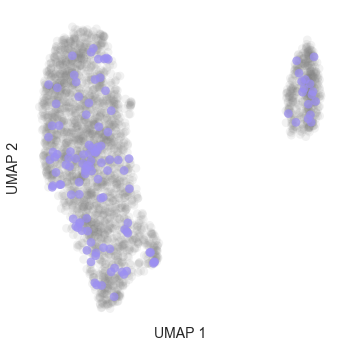

In [117]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[2]])

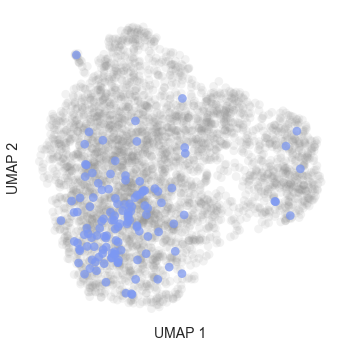

In [116]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[2]])

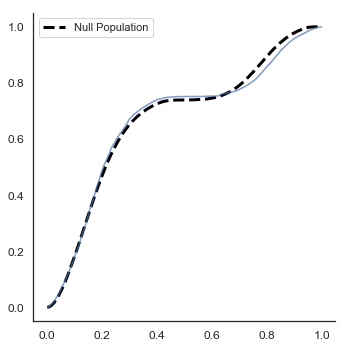

CPU times: user 2.39 s, sys: 240 ms, total: 2.63 s
Wall time: 2.43 s


,EMD,KLD,code
0,0.014098,6.421543,CTGAGTCACTCACTGAGTGT


In [164]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[2]])

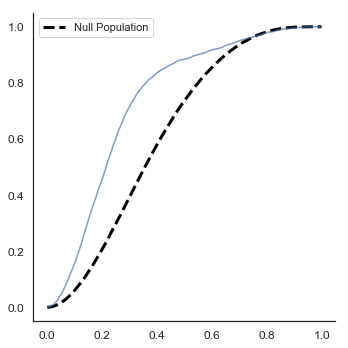

CPU times: user 3.46 s, sys: 306 ms, total: 3.77 s
Wall time: 3.55 s


,EMD,KLD,code
0,0.115927,6.777993,CTGAGTCACTCACTGAGTGT


In [165]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[2]])

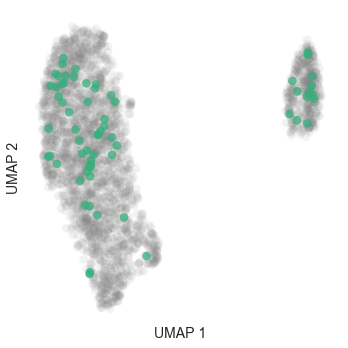

In [129]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[7]])

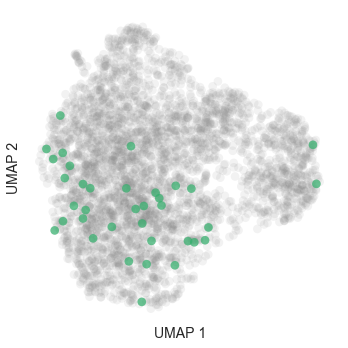

In [128]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[7]])

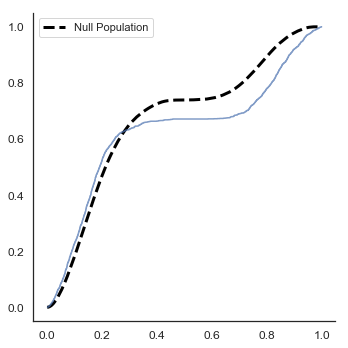

CPU times: user 2.54 s, sys: 270 ms, total: 2.81 s
Wall time: 2.7 s


,EMD,KLD,code
0,0.059997,7.703146,CTGACTGTCAGACAGAGTGA


In [166]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[7]])

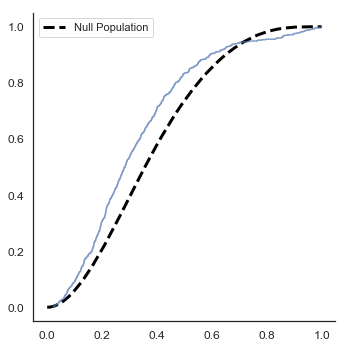

CPU times: user 3.59 s, sys: 356 ms, total: 3.95 s
Wall time: 3.81 s


,EMD,KLD,code
0,0.059923,9.242577,CTGACTGTCAGACAGAGTGA


In [167]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[7]])

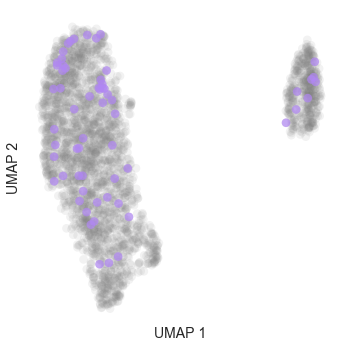

In [127]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[8]])

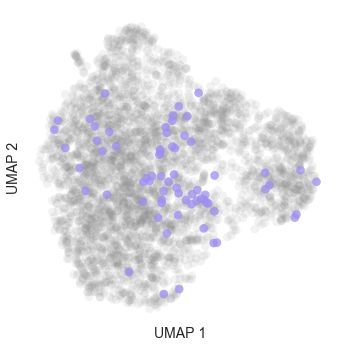

In [126]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[8]])

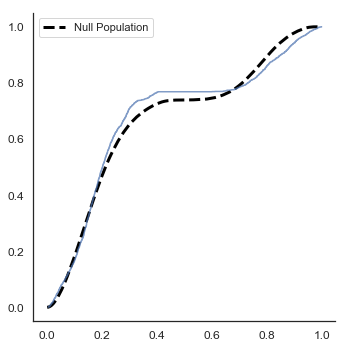

CPU times: user 2.65 s, sys: 746 ms, total: 3.4 s
Wall time: 3.59 s


,EMD,KLD,code
0,0.026674,7.75854,CTGAGTCAGTCACACTCTGT


In [168]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[8]])

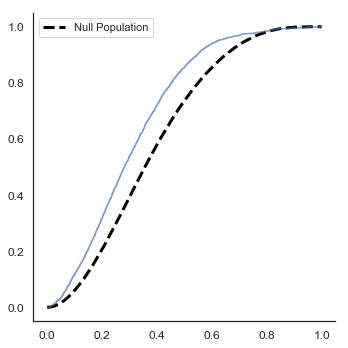

CPU times: user 3.59 s, sys: 301 ms, total: 3.9 s
Wall time: 3.73 s


,EMD,KLD,code
0,0.06991,7.944516,CTGAGTCAGTCACACTCTGT


In [169]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[8]])

...and significant untreated populations:

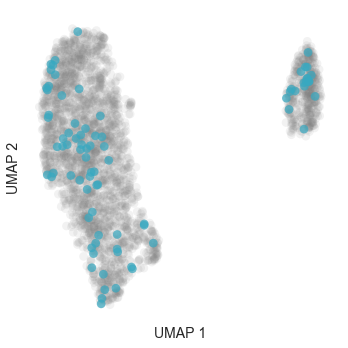

In [93]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[5]])

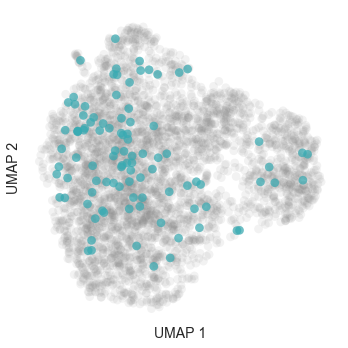

In [119]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[5]])

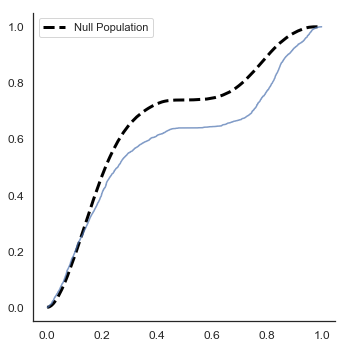

CPU times: user 2.41 s, sys: 255 ms, total: 2.66 s
Wall time: 2.47 s


,EMD,KLD,code
0,0.0796,7.140736,CTGAGAGACTCTGTGACTGA


In [160]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[5]])

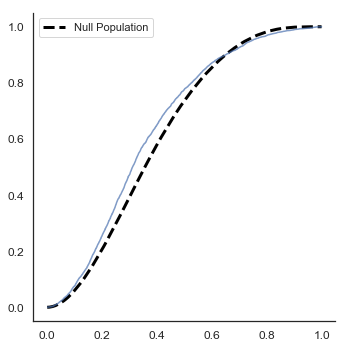

CPU times: user 3.49 s, sys: 333 ms, total: 3.82 s
Wall time: 3.58 s


,EMD,KLD,code
0,0.030385,7.22351,CTGAGAGACTCTGTGACTGA


In [161]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[5]])

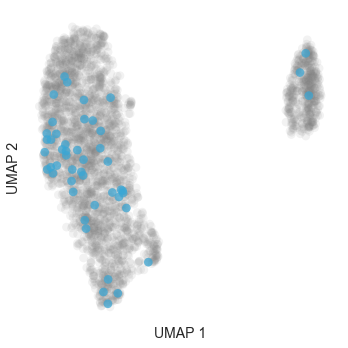

In [94]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[11]])

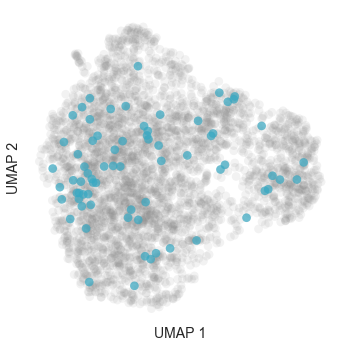

In [121]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[11]])

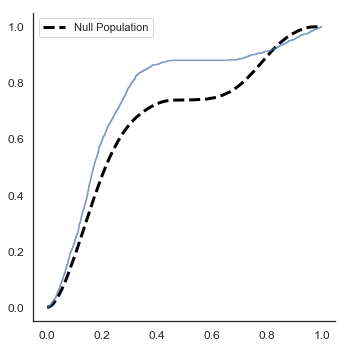

CPU times: user 2.41 s, sys: 264 ms, total: 2.67 s
Wall time: 2.52 s


,EMD,KLD,code
0,0.087073,8.248442,CTGAGAGTCACTGAGTGTGT


In [162]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[11]])

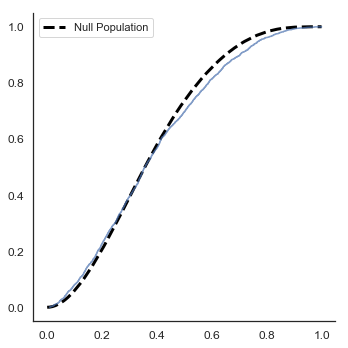

CPU times: user 3.57 s, sys: 397 ms, total: 3.97 s
Wall time: 3.77 s


,EMD,KLD,code
0,0.019371,7.848853,CTGAGAGTCACTGAGTGTGT


In [163]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[11]])

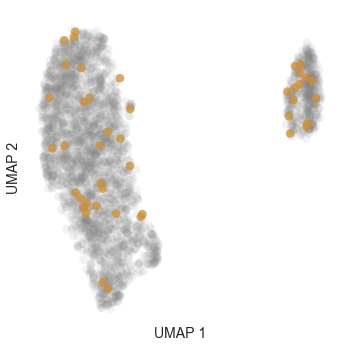

In [95]:
U_vg_UMAP.plot_barcodes(ranks=[selected_codes[13]])

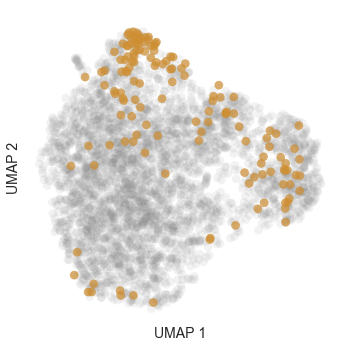

In [123]:
I_vg_UMAP.plot_barcodes(ranks=[selected_codes[13]])

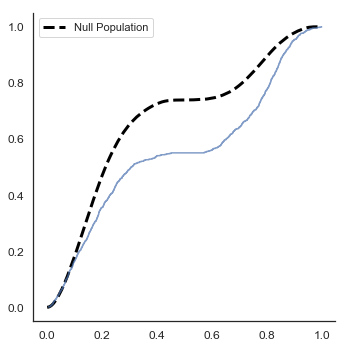

CPU times: user 2.4 s, sys: 305 ms, total: 2.71 s
Wall time: 2.54 s


,EMD,KLD,code
0,0.115036,8.393087,CTGACAGACACTCTCAGTCT


In [158]:
%%time
compare_barcode_distances(obj=U_vg_UMAP, barcodes=[selected_codes[13]])

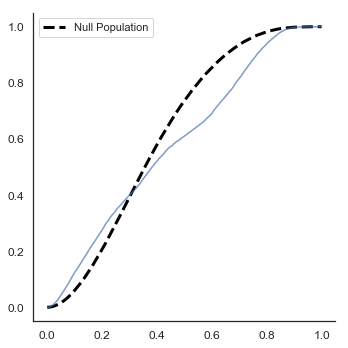

CPU times: user 3.62 s, sys: 360 ms, total: 3.98 s
Wall time: 3.82 s


,EMD,KLD,code
0,0.065948,6.542854,CTGACAGACACTCTCAGTCT


In [159]:
%%time
compare_barcode_distances(obj=I_vg_UMAP, barcodes=[selected_codes[13]])